In [1]:
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

In [211]:
import numpy as np
import cv2 as cv
import pandas as pd
import os

In [267]:
import matplotlib.pyplot as plt

class Debug():
    class Image():
        def __init__(self,image,label=""):
            self.image = image
            self.label = label
            
    def show_images_list(image_list, labels = [], cmap = 'gray', col_number = 10, height = 2, save_name=None, save_dir = "Data/saved_images"):
        row = -(-len(image_list)//col_number) 
        fig = plt.figure(figsize=(15, row*height))
        count = 1
        
        if save_name:
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
        
        for i in range(len(image_list)):
            a = fig.add_subplot(row, col_number, count)
            plt.axis('off')
            if isinstance(img, Debug.Image):
                if image_list[i].label:
                    a.set_title(image_list[i].label)
                plt.imshow(image_list[i].image, cmap = cmap) 
            else:
                if any(labels):
                    a.set_title(labels[i])
                out_img = plt.imshow(image_list[i], cmap = cmap) 
            if save_name:
                plt.imsave(os.path.join(save_dir, "%s_%s.png"%(save_name,i)), image_list[i], cmap = cmap)
            count=count+1
            
    def show_image(img, cmap = 'gray'):
        plt.imshow(img, cmap = cmap) 
        
    def scale_to_1(x):
        return (x/255.0)
    
    def scale_to_255(x):
        return (x*255.0)
        
    def make_rgb_from_gray(img, mode="r"):
        img = img.reshape(-1,28,28,1)
        out_shape = list(img.shape)
        out_shape[-1] = 2
        out = np.concatenate((img, np.zeros(out_shape)), axis=3)
        if mode == "r":
            return out
        if mode == "g":
            return out[:,:,:,[1,0,2]]
        if mode == "b":
            return out[:,:,:,[1,2,0]]

#Example: debug_img_list.append(Debug.Image(img,"label"))
#Example: Debug.show_images_list(debug_img_list, col_number = 3, height = 5)

In [5]:
###Get dataset
mnist_train = pd.read_csv('Data/digit-recognizer/train.csv').astype(np.float32)
mnist_test = pd.read_csv('Data/digit-recognizer/test.csv').astype(np.float32)

In [238]:
y_train = np.array(mnist_train[['label']][:20])[:,0]
x_train = np.array(mnist_train[['pixel' + str(idx) for idx in range(784)]][:20]).reshape([-1,28,28])

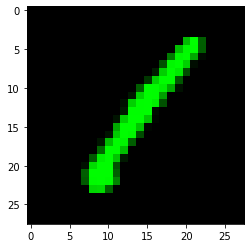

In [271]:
#Make red from gray
x_train_sc1 = Debug.scale_to_1(x_train)
x_train_Rgb = Debug.make_rgb_from_gray(x_train_sc1, mode="g")
Debug.show_image(x_train_Rgb[0])

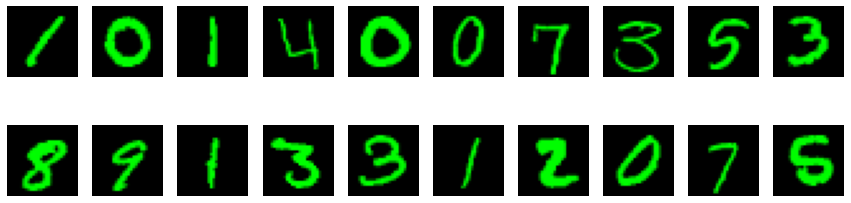

In [273]:
#$img = x_train[0].reshape([28,28])
out = Debug.show_images_list(x_train_Rgb)

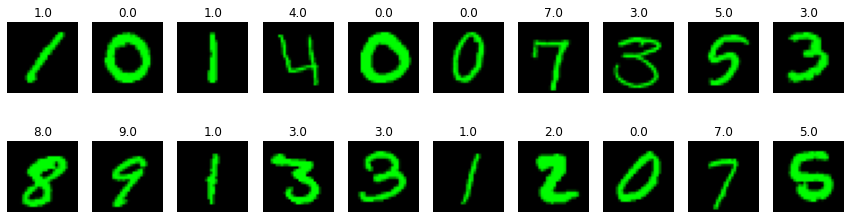

In [277]:
#Debug.show_image(img, cmap="gray")
#Debug.show_images_list(x_train_Rgb, y_train) #save_name="out"
Debug.show_images_list(x_train_Rgb, y_train, save_name="out") 

